# Tune the algorithms designed for stationary environments

In this notebook I tune the hyper parameters of those algorithms that were designed to work in stationary environments. These include: Epsilon-greedy, UCB1, LinUCB and SimOOS

For this I run them on the first 5000 points of the dataset without introducing non-stationarity.
In later experiments i will use the tuned parameters for these algorithms.

Here I use contexts of size 4.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
# all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 4)

In [15]:
all_contexts

array([[1, 1, 1, 2],
       [1, 1, 1, 3],
       [1, 1, 1, 1],
       ...,
       [4, 3, 2, 2],
       [4, 3, 2, 3],
       [4, 3, 2, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [18]:
# Drop arms with small rewards

In [19]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [20]:
y[y == 2] = 4

In [21]:
y[y == 3] = 4

In [22]:
y.value_counts()

4    4596
1    4320
5    4044
Name: final evaluation, dtype: int64

In [23]:
np.sum(np.where(y == 3, 1, 0))

0

In [24]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [25]:
all_rewards

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [26]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4596, 4044])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [27]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((all_rewards.shape[1], all_contexts.shape[1]))
for n_arm in range(all_rewards.shape[1]):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[ 5.95789122e-07 -1.09000277e-07  2.93197482e-07 -1.18003215e+01]]
1
[[-0.18603078 -0.33239928 -0.26522023  1.05266489]]
2
[[0.23537151 0.42056171 0.33544766 1.71326315]]


In [28]:
np.mean(coefs, axis= 0)

array([ 0.01644711,  0.02938744,  0.02340924, -3.01146448])

## Algorithm evaluation

In [29]:
BETA = 1

In [30]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [31]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.ones(new_rewards.shape)*np.mean(new_rewards, axis=0)

n_arms = all_rewards.shape[1]



In [32]:
new_contexts.shape, new_rewards.shape

((12960, 4), (12960, 3))

### Stationary costs

In [33]:
cost_change_points = []
interval_count = len(cost_change_points) + 1

In [34]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [35]:
interval_means

[array([0.0174908 , 0.02901429, 0.02463988, 0.02197317])]

In [36]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [37]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

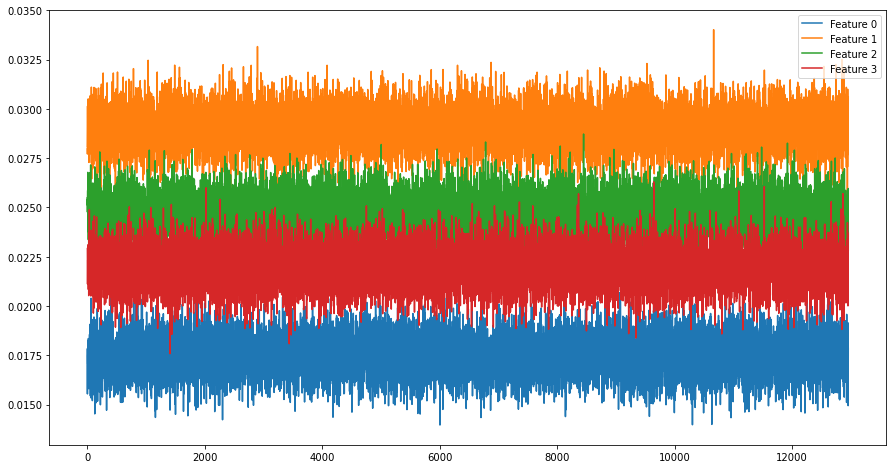

In [38]:
plot_costs(get_costs(), new_contexts.shape[0])

In [39]:
costs_obj = get_costs()

In [40]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [41]:
costs_vector.shape

(12960, 4)

## Plot expected reward

Min expected reward for arm 1: 0.3333333333333333
Min expected reward for arm 2: 0.35462962962962963
Min expected reward for arm 3: 0.31203703703703706


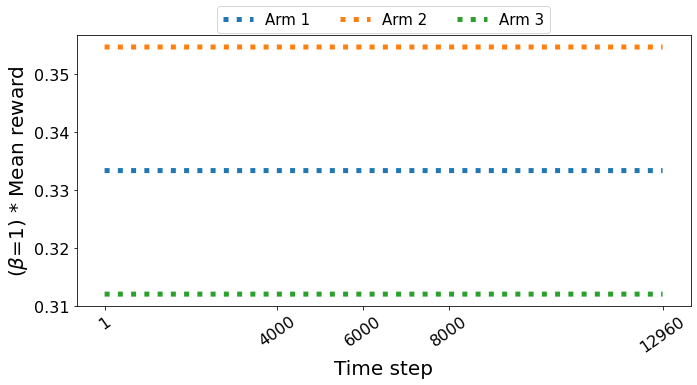

In [42]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 4000, 6000, 8000, 12960]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Plot expected reward minus sum of costs

Min expected gain for arm 1: 0.23124523004844777
Min expected gain for arm 2: 0.2525415263447441
Min expected gain for arm 3: 0.2099489337521515


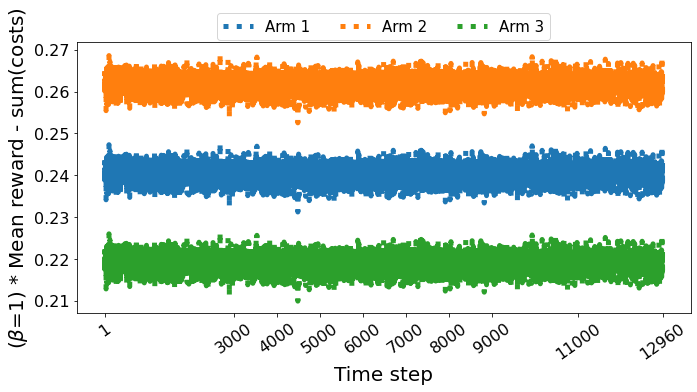

In [43]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Testing on non-stationary data

In [44]:
np.random.seed(42)

In [45]:
TUNING_NUM_OF_TRIALS = 5000
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

## Epsilon-greedy

In [46]:
egreedy_gains = {}

for eps in [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):
        egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=new_rewards.shape[1])

        gain_egreedy = evaluation.evaluate_on_synthetic_data(
            egreedy,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_egreedy

    gain_egreedy = np.mean(gains, axis=0)
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1759.0
	Total reward: 1759.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 2279.0
	Total reward: 2279.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1665.0
	Total reward: 1665.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1835.0
	Total reward: 1835.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1666.0
	Total reward: 1666.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 2420.0
	Total reward: 2420.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1782.0
	Total reward: 1782.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 2455.0
	Total reward: 2455.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 2573.0
	Total reward: 2573.0
	Total cost: 0
Execution time: 0.0s
E-greedy(e

In [47]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0];
best_eps

0.01

In [48]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4506.0
	Total reward: 4506.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4338.0
	Total reward: 4338.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 5891.0
	Total reward: 5891.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4539.0
	Total reward: 4539.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4761.0
	Total reward: 4761.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4807.0


## UCB1

In [49]:
ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        ucb_alg = algorithms.UCB1(
                n_trials=TUNING_NUM_OF_TRIALS,
                n_arms=new_rewards.shape[1],
                alpha=alpha,
            )

        gain_ucb = evaluation.evaluate_on_synthetic_data(
            ucb_alg,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_ucb

    gain_ucb = np.mean(gains, axis=0)
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.001)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 2575.0
	Total reward: 2575.0
	Total cost: 0
Execution t

In [50]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_ucb

0.5

In [51]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=best_alpha_ucb,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.5)
Beta = 1
Total gain: 7013.0
	Total reward: 7013.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.5)
Beta = 1
Total gain: 7013.0
	Total reward: 7013.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.5)
Beta = 1
Total gain: 7013.0
	Total reward: 7013.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.5)
Beta = 1
Total gain: 7013.0
	Total reward: 7013.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.5)
Beta = 1
Total gain: 7013.0
	Total reward: 7013.0
	Total cost: 0
Execution time: 0.1s
Average gain: 7013.0


## LinUCB

In [52]:
linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        linucb = algorithms.LinUCB(
            n_trials=TUNING_NUM_OF_TRIALS,
            context_dimension=new_contexts.shape[1],
            n_arms=new_rewards.shape[1],
            alpha=alpha,
        )
        gain_linucb = evaluation.evaluate_on_synthetic_data(
            linucb,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_linucb

    gain_linucb = np.mean(gains, axis=0)
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.001)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.2s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.2s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.3s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 2109.308296172824
	Total reward: 2575.0
	Total cost: 465.6917038271713
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 2109.308296172824
	T

LinUCB (alpha=0.9)
Beta = 1
Total gain: 3512.308296172831
	Total reward: 3978.0
	Total cost: 465.6917038271713
Execution time: 0.2s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 3512.308296172831
	Total reward: 3978.0
	Total cost: 465.6917038271713
Execution time: 0.3s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 3512.308296172831
	Total reward: 3978.0
	Total cost: 465.6917038271713
Execution time: 0.2s


In [53]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_linucb

0.7

In [54]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_linucb,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.7)
Beta = 1
Total gain: 9089.204394047863
	Total reward: 10296.0
	Total cost: 1206.7956059521268
Execution time: 0.6s
LinUCB (alpha=0.7)
Beta = 1
Total gain: 9089.204394047863
	Total reward: 10296.0
	Total cost: 1206.7956059521268
Execution time: 0.7s
LinUCB (alpha=0.7)
Beta = 1
Total gain: 9089.204394047863
	Total reward: 10296.0
	Total cost: 1206.7956059521268
Execution time: 0.7s
LinUCB (alpha=0.7)
Beta = 1
Total gain: 9089.204394047863
	Total reward: 10296.0
	Total cost: 1206.7956059521268
Execution time: 0.6s
LinUCB (alpha=0.7)
Beta = 1
Total gain: 9089.204394047863
	Total reward: 10296.0
	Total cost: 1206.7956059521268
Execution time: 0.6s
Average gain: 9089.204394047863


## SimOOS

In [55]:
simoos_gains = {}


for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.12, 0.16, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta_SimOOS=BETA,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                new_contexts[:TUNING_NUM_OF_TRIALS],
                new_rewards[:TUNING_NUM_OF_TRIALS],
                costs_vector[:TUNING_NUM_OF_TRIALS],
                beta=BETA,
                stop_after=TUNING_NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_simoos

    gain_simoos = np.mean(gains, axis=0)
    simoos_gains[delta] = gain_simoos

Took 0.0011968612670898438 seconds
Trial 0, time 2022-05-10 16:59:05.840328
Trial 500, time 2022-05-10 16:59:15.816505
Trial 1000, time 2022-05-10 16:59:17.386921
Trial 1500, time 2022-05-10 16:59:17.529965
Trial 2000, time 2022-05-10 16:59:22.540728
Trial 2500, time 2022-05-10 16:59:22.686989
Trial 3000, time 2022-05-10 16:59:22.843386
Trial 3500, time 2022-05-10 16:59:22.929189
Trial 4000, time 2022-05-10 16:59:23.082506
Trial 4500, time 2022-05-10 16:59:23.218972
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 2172.7711510863205
	Total reward: 2482.0
	Total cost: 309.2288489136835
Execution time: 17.5s
Took 17.511927127838135 seconds
Took 0.0013408660888671875 seconds
Trial 0, time 2022-05-10 16:59:23.353718
Trial 500, time 2022-05-10 16:59:29.455582
Trial 1000, time 2022-05-10 16:59:29.605939
Trial 1500, time 2022-05-10 16:59:29.860613
Trial 2000, time 2022-05-10 16:59:29.947645
Trial 2500, time 2022-05-10 16:59:30.091574
Trial 3000, time 2022-05-10 16:59:30.183735
Trial 3500, ti

Trial 500, time 2022-05-10 17:02:21.344020
Trial 1000, time 2022-05-10 17:02:21.523558
Trial 1500, time 2022-05-10 17:02:21.720330
Trial 2000, time 2022-05-10 17:02:21.895333
Trial 2500, time 2022-05-10 17:02:22.016524
Trial 3000, time 2022-05-10 17:02:22.135589
Trial 3500, time 2022-05-10 17:02:22.312003
Trial 4000, time 2022-05-10 17:02:22.431665
Trial 4500, time 2022-05-10 17:02:22.552010
SimOOS (beta=1, delta=0.03)
Beta = 1
Total gain: 3623.1044461865117
	Total reward: 4088.0
	Total cost: 464.8955538134897
Execution time: 18.3s
Took 18.257181882858276 seconds
Took 0.0014829635620117188 seconds
Trial 0, time 2022-05-10 17:02:22.678780
Trial 500, time 2022-05-10 17:02:35.484070
Trial 1000, time 2022-05-10 17:02:40.912579
Trial 1500, time 2022-05-10 17:02:41.130023
Trial 2000, time 2022-05-10 17:02:41.253750
Trial 2500, time 2022-05-10 17:02:41.430051
Trial 3000, time 2022-05-10 17:02:41.549735
Trial 3500, time 2022-05-10 17:02:41.669680
Trial 4000, time 2022-05-10 17:02:41.856219
Tri

Trial 500, time 2022-05-10 17:05:10.026530
Trial 1000, time 2022-05-10 17:05:19.587665
Trial 1500, time 2022-05-10 17:05:19.730865
Trial 2000, time 2022-05-10 17:05:19.889253
Trial 2500, time 2022-05-10 17:05:19.976053
Trial 3000, time 2022-05-10 17:05:20.278743
Trial 3500, time 2022-05-10 17:05:20.371062
Trial 4000, time 2022-05-10 17:05:20.458528
Trial 4500, time 2022-05-10 17:05:20.556310
SimOOS (beta=1, delta=0.09)
Beta = 1
Total gain: 1890.8026247460994
	Total reward: 2223.0
	Total cost: 332.19737525390383
Execution time: 27.1s
Took 27.132479906082153 seconds
Took 0.005539894104003906 seconds
Trial 0, time 2022-05-10 17:05:34.482206
Trial 500, time 2022-05-10 17:05:35.561689
Trial 1000, time 2022-05-10 17:05:35.680647
Trial 1500, time 2022-05-10 17:05:35.796524
Trial 2000, time 2022-05-10 17:05:35.862757
Trial 2500, time 2022-05-10 17:05:35.990901
Trial 3000, time 2022-05-10 17:05:36.060395
Trial 3500, time 2022-05-10 17:05:36.125985
Trial 4000, time 2022-05-10 17:05:36.192692
Tri

Trial 500, time 2022-05-10 17:08:32.235018
Trial 1000, time 2022-05-10 17:08:32.500758
Trial 1500, time 2022-05-10 17:08:32.719385
Trial 2000, time 2022-05-10 17:08:32.940051
Trial 2500, time 2022-05-10 17:08:33.089209
Trial 3000, time 2022-05-10 17:08:33.248951
Trial 3500, time 2022-05-10 17:08:33.393881
Trial 4000, time 2022-05-10 17:08:43.802131
Trial 4500, time 2022-05-10 17:08:44.588890
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 3263.0769640915914
	Total reward: 3696.0
	Total cost: 432.92303590840896
Execution time: 33.5s
Took 33.49706435203552 seconds
Took 0.0018949508666992188 seconds
Trial 0, time 2022-05-10 17:08:44.842843
Trial 500, time 2022-05-10 17:09:04.897934
Trial 1000, time 2022-05-10 17:09:05.090060
Trial 1500, time 2022-05-10 17:09:05.315355
Trial 2000, time 2022-05-10 17:09:05.535600
Trial 2500, time 2022-05-10 17:09:05.667989
Trial 3000, time 2022-05-10 17:09:05.832948
Trial 3500, time 2022-05-10 17:09:06.060383
Trial 4000, time 2022-05-10 17:09:06.193441
Tri

Trial 500, time 2022-05-10 17:11:50.965263
Trial 1000, time 2022-05-10 17:11:51.141338
Trial 1500, time 2022-05-10 17:11:51.329058
Trial 2000, time 2022-05-10 17:11:52.244486
Trial 2500, time 2022-05-10 17:11:58.608330
Trial 3000, time 2022-05-10 17:11:58.759239
Trial 3500, time 2022-05-10 17:11:58.962056
Trial 4000, time 2022-05-10 17:11:59.082985
Trial 4500, time 2022-05-10 17:11:59.238766
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 1850.0960823292833
	Total reward: 2183.0
	Total cost: 332.90391767071463
Execution time: 19.6s
Took 19.631709098815918 seconds
Took 0.0027909278869628906 seconds
Trial 0, time 2022-05-10 17:11:59.338380
Trial 500, time 2022-05-10 17:12:11.765740
Trial 1000, time 2022-05-10 17:12:11.946214
Trial 1500, time 2022-05-10 17:12:12.421850
Trial 2000, time 2022-05-10 17:12:13.360200
Trial 2500, time 2022-05-10 17:12:15.841177
Trial 3000, time 2022-05-10 17:12:21.333348
Trial 3500, time 2022-05-10 17:12:21.966345
Trial 4000, time 2022-05-10 17:12:22.637397
Tri

Trial 500, time 2022-05-10 17:15:45.618087
Trial 1000, time 2022-05-10 17:15:45.958907
Trial 1500, time 2022-05-10 17:15:46.148702
Trial 2000, time 2022-05-10 17:15:46.290799
Trial 2500, time 2022-05-10 17:15:46.432712
Trial 3000, time 2022-05-10 17:15:46.582060
Trial 3500, time 2022-05-10 17:15:46.684757
Trial 4000, time 2022-05-10 17:15:46.783568
Trial 4500, time 2022-05-10 17:15:46.879611
SimOOS (beta=1, delta=0.6)
Beta = 1
Total gain: 2656.222280122307
	Total reward: 2919.0
	Total cost: 262.7777198776853
Execution time: 9.6s
Took 9.56026315689087 seconds
Took 0.005892038345336914 seconds
Trial 0, time 2022-05-10 17:15:47.337335
Trial 500, time 2022-05-10 17:15:52.705901
Trial 1000, time 2022-05-10 17:15:55.811497
Trial 1500, time 2022-05-10 17:15:56.818468
Trial 2000, time 2022-05-10 17:15:59.517512
Trial 2500, time 2022-05-10 17:16:00.178676
Trial 3000, time 2022-05-10 17:16:06.681636
Trial 3500, time 2022-05-10 17:16:10.523728
Trial 4000, time 2022-05-10 17:16:10.835148
Trial 450

Trial 500, time 2022-05-10 17:19:25.501839
Trial 1000, time 2022-05-10 17:19:25.627040
Trial 1500, time 2022-05-10 17:19:25.701223
Trial 2000, time 2022-05-10 17:19:25.855520
Trial 2500, time 2022-05-10 17:19:25.933516
Trial 3000, time 2022-05-10 17:19:26.006070
Trial 3500, time 2022-05-10 17:19:26.079324
Trial 4000, time 2022-05-10 17:19:26.215524
Trial 4500, time 2022-05-10 17:19:26.297244
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 3984.9617389520404
	Total reward: 4218.0
	Total cost: 233.03826104795436
Execution time: 2.9s
Took 2.889914035797119 seconds
Took 0.0015017986297607422 seconds
Trial 0, time 2022-05-10 17:19:26.382806
Trial 500, time 2022-05-10 17:19:33.643161
Trial 1000, time 2022-05-10 17:19:49.588424
Trial 1500, time 2022-05-10 17:19:49.780267
Trial 2000, time 2022-05-10 17:19:49.996565
Trial 2500, time 2022-05-10 17:19:50.170212
Trial 3000, time 2022-05-10 17:19:50.307148
Trial 3500, time 2022-05-10 17:19:50.433477
Trial 4000, time 2022-05-10 17:19:50.571326
Trial

In [56]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_delta_simoos

0.03

In [57]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=best_delta_simoos,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.009540796279907227 seconds
Trial 0, time 2022-05-10 17:23:58.611530
Trial 500, time 2022-05-10 17:24:01.884148
Trial 1000, time 2022-05-10 17:24:13.846535
Trial 1500, time 2022-05-10 17:24:13.997729
Trial 2000, time 2022-05-10 17:24:14.138636
Trial 2500, time 2022-05-10 17:24:14.240502
Trial 3000, time 2022-05-10 17:24:14.559766
Trial 3500, time 2022-05-10 17:24:14.661941
Trial 4000, time 2022-05-10 17:24:14.749087
Trial 4500, time 2022-05-10 17:24:14.841954
Trial 5000, time 2022-05-10 17:24:14.990193
Trial 5500, time 2022-05-10 17:24:15.085952
Trial 6000, time 2022-05-10 17:24:15.252193
Trial 6500, time 2022-05-10 17:24:15.345541
Trial 7000, time 2022-05-10 17:24:15.434419
Trial 7500, time 2022-05-10 17:24:15.521066
Trial 8000, time 2022-05-10 17:24:15.641138
Trial 8500, time 2022-05-10 17:24:15.766194
Trial 9000, time 2022-05-10 17:24:15.874948
Trial 9500, time 2022-05-10 17:24:16.008155
Trial 10000, time 2022-05-10 17:24:16.090739
Trial 10500, time 2022-05-10 17:24:16.178576


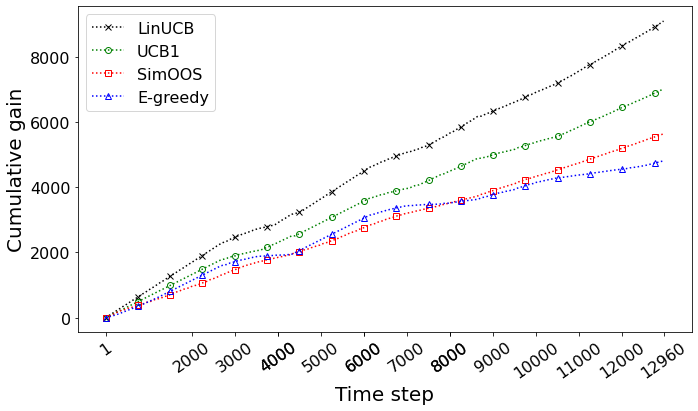

In [58]:
plot_gains({
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'SimOOS': gain_simoos,
},
)


In [59]:
best_eps # Epsilon-greedy

0.01

In [60]:
best_alpha_ucb # UCB1

0.5

In [61]:
best_alpha_linucb # LinUCB

0.7

In [62]:
best_delta_simoos # SimOOS

0.03